# DS-GA 1011 Fall 2017 HW 01
# Bags of Words and Document Classification

In [23]:
import numpy as np
import os
import torch
import collections
from collections import Counter
from sklearn.feature_extraction import stop_words
from torch.utils.data import Dataset
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable

In [91]:
# (some of the) hyper parameters
learning_rate = 0.001
vocab_size = 20000 # number words in the vocabulary base
emb_dim = 200 # dimension for n-gram embedding
num_epochs = 5 # number epoch to train
batch_size = 32
ngram_n = 2 # the n in n-gram

In [92]:
# I/O Param
data_dir = "./aclImdb/"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
TRAIN_SIZE = 23000
VALIDATION_SIZE = 2000
TEST_SIZE = 25000
PADDING_IDX = 0

## Part I : Data I/O
Read data from disk and parse them into desired structures

In [93]:
class IMDBDatum():
    """
    Class that represents a train/validation/test datum
    - self.raw_text
    - self.label: 0 neg, 1 pos
    - self.file_name: dir for this datum
    - self.tokens: list of tokens
    - self.token_idx: index of each token in the text
    """
    def __init__(self, raw_text, label, file_name):
        self.raw_text = raw_text
        self.label = label
        self.file_name = file_name
        
    def set_ngram(self, ngram_ctr):
        self.ngram = ngram_ctr
    
    def set_token_idx(self, token_idx):
        self.token_idx = token_idx
        
    def set_tokens(self, tokens):
        self.tokens = tokens


def preprocess_text(text):
    """
    Function that cleans the string
    """
    text = text.lower().replace("<br />", "")
    return text
        
    
def read_file_as_datum(file_name, label):
    """
    Function that reads a file 
    """
    with open(file_name, "r") as f:
        content = f.read()
        content = preprocess_text(content)
    return IMDBDatum(raw_text=content, label=label, file_name=file_name)


def construct_dataset(dataset_dir, dataset_size, offset=0):
    """
    Function that loads a dataset
    @param offset: skip first offset items in this dir
    """
    pos_dir = os.path.join(dataset_dir, "pos")
    neg_dir = os.path.join(dataset_dir, "neg")
    single_label_size = int(dataset_size / 2)
    output = []
    all_pos = os.listdir(pos_dir)
    all_neg = os.listdir(neg_dir)
    for i in range(offset, offset+single_label_size):
        output.append(read_file_as_datum(os.path.join(pos_dir, all_pos[i]), 1))
        output.append(read_file_as_datum(os.path.join(neg_dir, all_neg[i]), 0))
    return output


In [94]:
# Load Dataset - should take less than 1 min
train_set = construct_dataset(train_dir, TRAIN_SIZE)
validation_set = construct_dataset(train_dir, VALIDATION_SIZE, offset=int(TRAIN_SIZE/2))
test_set = construct_dataset(test_dir, TEST_SIZE)

## Part II: Feature Engineering - Bag of N-gram

You will find the Python Counter object very helpful in this part of the assignment.

Please refer to https://docs.python.org/2/library/collections.html#collections.Counter for more info.

In [95]:
def extract_ngram_from_text(text, n, remove_stopwords=True):
    """
    Function that retrieves all n-grams from the input string
    @param text: raw string
    @param n: integer that tells the model to retrieve all k-gram where k<=n
    @return ngram_counter: a counter that maps n-gram to its frequency
    @return tokens: a list of parsed ngrams
    """
    # tokenize words - for simplicity just split by space
    tokens = text.split(" ")
    if remove_stopwords:
        tokens = [token for token in tokens if token not in stop_words.ENGLISH_STOP_WORDS]
        
    all_ngrams = []
    all_ngrams.append(tokens)
    
    for i in np.arange(2, n+1):
        ngram = list(zip(*[tokens[j:] for j in range(i)]))
        all_ngrams.append(ngram)
    
    all_ngrams = [item for sublist in all_ngrams for item in sublist]
    ngram_counter = Counter()
    
    for gram in all_ngrams:
        ngram_counter[gram] += 1

    return ngram_counter, all_ngrams


def construct_ngram_indexer(ngram_counter_list, topk):
    """
    Function that selects the most common topk ngrams
    @param ngram_counter_list: list of counters
    @param topk, int: # of 
    @return ngram2idx: a dictionary that maps ngram to an unique index
    """
    # TODO: fill in your code here
    # find the top k ngram
    # maps the ngram to an unique index
        
    d = []
    ngram_indexer = {}
    idx = np.arange(2, topk+2)
    ngram_counter = Counter()
    for n in ngram_counter_list:
        ngram_counter.update(n)

    top = ngram_counter.most_common(topk)
    for i, key in zip(np.arange(topk), top):
        ngram_indexer[key[0]] = idx[i]
    return ngram_indexer


def token_to_index(tokens, ngram_indexer):
    """
    Function that transform a list of tokens to a list of token index.
    @param tokens: list of ngram
    @param ngram_indexer: a dictionary that maps ngram to an unique index
    """
    # TODO: replace with your code
    # Please DO NOT assign any ngram to index 0 which is reserved for PAD token
    index_list = []
    
    for token in tokens:
        if token in ngram_indexer:
            index_list.append(ngram_indexer[token])
        else:
            index_list.append(1)
    return index_list


def process_text_dataset(dataset, n, topk=None, ngram_indexer=None):
    """
    Top level function that encodes each datum into a list of ngram indices
    @param dataset: list of IMDBDatum
    @param n: n in "n-gram"
    @param topk: #
    @param ngram_indexer: a dictionary that maps ngram to an unique index
    """
    # extract n-gram
    for i in range(len(dataset)):
        text_datum = dataset[i].raw_text
        ngrams, tokens = extract_ngram_from_text(text_datum, n)
        dataset[i].set_ngram(ngrams)
        dataset[i].set_tokens(tokens)
    # select top k ngram
    if ngram_indexer is None:
        ngram_indexer = construct_ngram_indexer([datum.ngram for datum in dataset], topk)
    # vectorize each datum
    for i in range(len(dataset)):
        dataset[i].set_token_idx(token_to_index(dataset[i].tokens, ngram_indexer))  
    return dataset, ngram_indexer

In [96]:
train_data, train_ngram_indexer = process_text_dataset(train_set, ngram_n, vocab_size)

In [97]:
validation_data, _ = process_text_dataset(validation_set, ngram_n, ngram_indexer=train_ngram_indexer)

In [98]:
test_data, _ = process_text_dataset(test_set, ngram_n, ngram_indexer=train_ngram_indexer)

## Part III: Construct Input Pipeline for PyTorch

In [99]:
class IMDBDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list):
        """
        @param data_list: list of IMDBDatum
        """
        self.data_list = data_list
        
    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        token_idx, label = self.data_list[key].token_idx, self.data_list[key].label
        return (token_idx, len(token_idx)), label
    

def imdb_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    for datum in batch:
        label_list.append(datum[1])
        length_list.append(datum[0][1])
    max_length = np.max(length_list)
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0][0]), 
                                pad_width=((0,max_length-datum[0][1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]
    

# consturct datasets
imdb_train = IMDBDataset(train_data)
imdb_validation = IMDBDataset(validation_data)
imdb_test = IMDBDataset(test_data)    
    
# construct data loader
train_loader = torch.utils.data.DataLoader(dataset=imdb_train, 
                                           batch_size=batch_size,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=imdb_validation, 
                                           batch_size=batch_size, 
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=imdb_test, 
                                           batch_size=batch_size,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)

In [100]:
print("This is an training sample: {0}".format(imdb_train[0][0]))
print("This is a label: {0}".format(imdb_train[0][1]))

This is an training sample: ([1285, 2099, 2872, 1487, 1023, 80, 395, 1, 97, 2206, 360, 3477, 8504, 3088, 645, 3473, 551, 5807, 1, 1, 2216, 2292, 3509, 12314, 1, 770, 3681, 5874, 1, 65, 2002, 1, 1, 7629, 2586, 7620, 1, 1, 1, 10760, 12328, 1, 19892, 465, 18132, 1, 1, 2178, 1, 4643, 2739, 1, 12277, 1, 69, 2999, 2002, 273, 1, 960, 1, 106, 1, 1, 3231, 9384, 1, 1, 7500, 4879, 107, 1, 554, 95, 1626, 7389, 3949, 5192, 1, 1921, 1, 491, 48, 1, 1458, 1, 250, 1, 10544, 1819, 14110, 491, 1, 676, 4248, 909, 6204, 480, 5260, 1128, 2002, 1, 718, 3130, 70, 445, 1347, 3, 1, 1058, 18, 5439, 256, 7, 1, 1458, 327, 150, 320, 2634, 733, 6086, 240, 1348, 981, 607, 1637, 145, 1924, 1, 320, 1432, 1, 9189, 1, 1, 4871, 1, 737, 844, 1, 15304, 6515, 80, 3, 844, 284, 1, 11456, 10037, 12144, 89, 693, 80, 978, 1633, 14387, 24, 408, 77, 383, 7477, 1, 32, 479, 337, 64, 6396, 1, 1, 1, 1, 1, 9218, 1, 1, 1, 1, 1, 1, 1, 7393, 1, 6475, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

## Part IV: Define Model

Please refers to https://arxiv.org/abs/1607.01759 for Fast Text model (Joulin et al.)

In [101]:
class FastText(nn.Module):
    """
    FastText model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(FastText, self).__init__()
        # TODO: replace with your code
        # Note that the # of inputs dimension for embedding shall be vocab_size+1, why?
        # In the embedding, you need to set the padding_dx argument.
        # Please see http://pytorch.org/docs/master/nn.html
        
        self.embed = nn.Embedding(vocab_size+2, emb_dim, padding_idx=0)
        self.dummy_layer = nn.Linear(emb_dim,1)
        
    
    def forward(self, data, length):
        """
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        # TODO: replace with your code
        # Note that instead of doing tensorwise mean, you need to calculate the sum and divide by the sentence length
        # in the length tensor.
        # The output of this function should be a Tensor of dimension (batch_size). Each of the dimension contains
        # a float in the range [0,1] that denotes the probability that the sample is positive (1).
        self.out = self.embed(data)
        self.out = torch.sum(self.out, dim=1) / length.unsqueeze(1).float()
        self.out = self.dummy_layer(self.out)
        return nn.functional.sigmoid(self.out.view(-1))

model = FastText(vocab_size, emb_dim)

## Part V: Define Loss Function and Optmizer

In [102]:
# Loss and Optimizer
criterion = nn.BCELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

## Part VI: Train and Test the Model

In [191]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = Variable(data), Variable(lengths), Variable(labels)
        outputs = model(data_batch, length_batch)
        predicted = (outputs.data > 0.5).long().view(-1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    model.train()
    return (100 * correct / total)


def early_stop(val_acc_history, t=2, required_progress=0.01):
    """
    Stop the training if there is no non-trivial progress in k steps
    @param val_acc_history: a list contains all the historical validation acc
    @param required_progress: the next acc should be higher than the previous by 
        at least required_progress amount to be non-trivial
    @param t: number of training steps 
    @return: a boolean indicates if the model should early stop
    """
    # TODO: add your code here
    if t <= 1:
        raise ValueError('Number of steps should be greater than 1')
    if len(val_acc_history) < (t+1):
        return False
    if np.abs(val_acc_history[-t] - validation_acc_history[-1]) < required_progress:
        return True
    return False

In [104]:
# Training the Model
validation_acc_history = []
stop_training = False
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        data_batch, length_batch, label_batch = Variable(data), Variable(lengths), Variable(labels)
        optimizer.zero_grad()
        try:
            outputs = model(data_batch, length_batch)
        except:
            print("Doesn't work for: " , torch.max(data_batch))
        loss = criterion(outputs, label_batch.float())
        loss.backward()
        optimizer.step()
        # report performance
        if (i+1) % (batch_size*4) == 0:
            train_acc = test_model(train_loader, model)
            val_acc = test_model(validation_loader, model)
            print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Train Acc: {5}, Validation Acc:{6}'.format( 
                   epoch+1, num_epochs, i+1, len(imdb_train)//batch_size, loss.data[0], 
                    train_acc, val_acc))
            validation_acc_history.append(val_acc)
            # check if we need to early stop the model
            stop_training = early_stop(validation_acc_history)
            if stop_training:
                torch.save(model.state_dict(), 'early-stopped-model.pkl')
                print("early stop triggered")
                break
    # because of the the nested loop
    if stop_training:
        break

Epoch: [1/5], Step: [128/718], Loss: 0.6864656805992126, Train Acc: 67.56521739130434, Validation Acc:67.3
Epoch: [1/5], Step: [256/718], Loss: 0.7041527628898621, Train Acc: 52.082608695652176, Validation Acc:51.55
Epoch: [1/5], Step: [384/718], Loss: 0.6437546014785767, Train Acc: 77.38260869565218, Validation Acc:76.1
Epoch: [1/5], Step: [512/718], Loss: 0.6091025471687317, Train Acc: 76.49565217391304, Validation Acc:74.8
Epoch: [1/5], Step: [640/718], Loss: 0.5785601139068604, Train Acc: 79.9608695652174, Validation Acc:77.75
Epoch: [2/5], Step: [128/718], Loss: 0.48023107647895813, Train Acc: 85.43913043478261, Validation Acc:84.35
Epoch: [2/5], Step: [256/718], Loss: 0.4084540009498596, Train Acc: 84.05652173913043, Validation Acc:82.1
Epoch: [2/5], Step: [384/718], Loss: 0.42949002981185913, Train Acc: 87.46521739130435, Validation Acc:85.25
Epoch: [2/5], Step: [512/718], Loss: 0.37551045417785645, Train Acc: 88.16956521739131, Validation Acc:85.45
Epoch: [2/5], Step: [640/718]

In [105]:
# Test the Model
print('Accuracy of the model on the test set: %d %%' % test_model(test_loader, model))

# Save the Model
#torch.save(model.state_dict(), 'model.pkl')

Accuracy of the model on the test set: 87 %


## Part VII: Error Analysis

In [109]:
def error_analysis(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    counter = 0
    false_pos = []
    false_neg = []
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = Variable(data), Variable(lengths), Variable(labels)
        outputs = model(data_batch, length_batch)
        predicted = (outputs.data > 0.5).long().view(-1)
        total += labels.size(0)
        if predicted[0] == 1 and labels[0] == 0 and len(false_pos) < 5:
            print('Predicted: ', predicted[0])
            print('Label: ', labels[0])
            print(counter)
            false_pos.append(counter)
        if predicted[0] == 0 and labels[0] == 1 and len(false_neg) < 5:
            print('Predicted: ', predicted[0])
            print('Label: ', labels[0])
            print(counter)
            false_neg.append(counter)
        correct += (predicted == labels).sum()
        counter += 1
    model.train()
    return (100 * correct / total), false_pos, false_neg

In [110]:
test_error = torch.utils.data.DataLoader(dataset=imdb_test, 
                                           batch_size=1,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)

In [111]:
error, false_pos_idx, false_neg_idx = error_analysis(test_error, model)

Predicted:  1
Label:  0
7
Predicted:  0
Label:  1
8
Predicted:  1
Label:  0
39
Predicted:  1
Label:  0
55
Predicted:  0
Label:  1
60
Predicted:  0
Label:  1
74
Predicted:  1
Label:  0
77
Predicted:  0
Label:  1
78
Predicted:  0
Label:  1
82
Predicted:  1
Label:  0
87


## False Positive Analysis

In [112]:
for i, idx in enumerate(false_pos_idx):
    print('-----------------------------')
    print('False Positive Number {}:'.format(i))
    print(test_set[idx].raw_text)

-----------------------------
False Positive Number 0:
eaten alive is a little film that opens in new york city and the arctic where tribe men shoot snake venom at a few people,then a woman enters the police precinct who's trying to find her sister that has disappeared after 6 months sheila is from alabama,but her accent sucks,she is teamed up with an adventurer who seems to just want her money and seems to say it a lot throughout the film.they venture through the amazon only to find a community with people and they find the sister,they're confronted by a mad man who has probably seen one too many jim jones preaches.he will bring them to a better place,it could be heaven but no,mark and sheila find out later its actually a suicide cult.why do i call eaten alive a "little film"? ill tell you but when i watched it,i was floored through all the run ins with the cannibals,robert kerman has a different role than his professor in cannibal holocaust.he's a bit annoying,once we meet him at an 

## False Negative Analysis

In [113]:
for i, idx in enumerate(false_neg_idx):
    print('-----------------------------')
    print('False Negative Number {}:'.format(i))
    print(test_set[idx].raw_text)

-----------------------------
False Negative Number 0:
okay, i'll say it. this movie made me laugh so hard that it hurt. this statement may offend some of you who may think that this movie is nothing more than a waste of film. but the thing that most people don't get is that this movie was intended to be bad and cheezy. i mean, did people actually think that a movie about a killer snowman was intended to be a masterpiece? just look at the "scary" hologram on the jacket of the movie and you'll find your answer. instead, like the original jack frost (which i thought was just as funny), this movie turned out to be a side-splitting journey into the depths of corny dialogue, bad one liners and horrible special effects. and it's all made to deliver laughter to us viewers. it certainly worked for me.for example: anne tiler (to her troubled husband): what makes you frown so heavily darling?if that chunk of dialogue doesn't make you laugh, then you have serious issues. who in their right mind w

## Part VIII: Parameter Tunning

### Learning Rate

In [118]:
def hyper_parameter_tune_lr_embedding(learning_rate=0.001, embedding_dim=200, vocab_size=20000, ngram_n=2, batch_size=32):
    train_data, train_ngram_indexer = process_text_dataset(train_set, ngram_n, vocab_size)
    validation_data, _ = process_text_dataset(validation_set, ngram_n, ngram_indexer=train_ngram_indexer)
    test_data, _ = process_text_dataset(test_set, ngram_n, ngram_indexer=train_ngram_indexer)
    # consturct datasets
    imdb_train = IMDBDataset(train_data)
    imdb_validation = IMDBDataset(validation_data)
    imdb_test = IMDBDataset(test_data)    

    # construct data loader
    train_loader = torch.utils.data.DataLoader(dataset=imdb_train, 
                                               batch_size=batch_size,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)
    validation_loader = torch.utils.data.DataLoader(dataset=imdb_validation, 
                                               batch_size=batch_size, 
                                               collate_fn=imdb_collate_func,
                                               shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=imdb_test, 
                                               batch_size=batch_size,
                                               collate_fn=imdb_collate_func,
                                               shuffle=False)
    model = FastText(vocab_size, emb_dim)
    criterion = nn.BCELoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    # Training the Model
    train_acc_history = []
    validation_acc_history = []
    stop_training = False
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            data_batch, length_batch, label_batch = Variable(data), Variable(lengths), Variable(labels)
            optimizer.zero_grad()
            try:
                outputs = model(data_batch, length_batch)
            except:
                print("Doesn't work for: " , torch.max(data_batch))
            loss = criterion(outputs, label_batch.float())
            loss.backward()
            optimizer.step()
            # report performance
            if (i+1) % (batch_size*20) == 0:
                train_acc = test_model(train_loader, model)
                val_acc = test_model(validation_loader, model)
                print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Train Acc: {5}, Validation Acc:{6}'.format( 
                       epoch+1, num_epochs, i+1, len(imdb_train)//batch_size, loss.data[0], 
                        train_acc, val_acc))
                train_acc_history.append(train_acc)
                validation_acc_history.append(val_acc)
                # check if we need to early stop the model
                stop_training = early_stop(validation_acc_history)
                if stop_training:
                    print("early stop triggered")
                    break
        # because of the the nested loop
        if stop_training:
            break
            
    return train_acc_history, validation_acc_history, test_model(test_loader, model)

In [122]:
embeds = []
embed_test_acc = []

for embed in [200, 500, 5000, 10000]:
    temp = hyper_parameter_tune_lr_embedding(embedding_dim=embed)
    embeds.append(temp)
    embed_test_acc.append(temp[2])
    print('Test Accuracy for Embedding Dim = {}: {}'.format(embed, temp[2]))

Epoch: [1/5], Step: [640/718], Loss: 0.5516489744186401, Train Acc: 81.58260869565217, Validation Acc:78.9
Epoch: [2/5], Step: [640/718], Loss: 0.22559240460395813, Train Acc: 88.6, Validation Acc:85.25
Epoch: [3/5], Step: [640/718], Loss: 0.2704969048500061, Train Acc: 91.26086956521739, Validation Acc:86.85
Epoch: [4/5], Step: [640/718], Loss: 0.20797663927078247, Train Acc: 92.85217391304347, Validation Acc:87.5
Epoch: [5/5], Step: [640/718], Loss: 0.09461188316345215, Train Acc: 93.92608695652174, Validation Acc:87.45
Test Accuracy for Embedding Dim = 200: 87.628
Epoch: [1/5], Step: [640/718], Loss: 0.5824289917945862, Train Acc: 77.40434782608696, Validation Acc:77.4
Epoch: [2/5], Step: [640/718], Loss: 0.3223384916782379, Train Acc: 88.68260869565218, Validation Acc:84.9
Epoch: [3/5], Step: [640/718], Loss: 0.12989778816699982, Train Acc: 91.11739130434782, Validation Acc:86.55
Epoch: [4/5], Step: [640/718], Loss: 0.2753960192203522, Train Acc: 92.7695652173913, Validation Acc:87

In [125]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [126]:
plt.rcParams['figure.figsize'] = (10, 8)

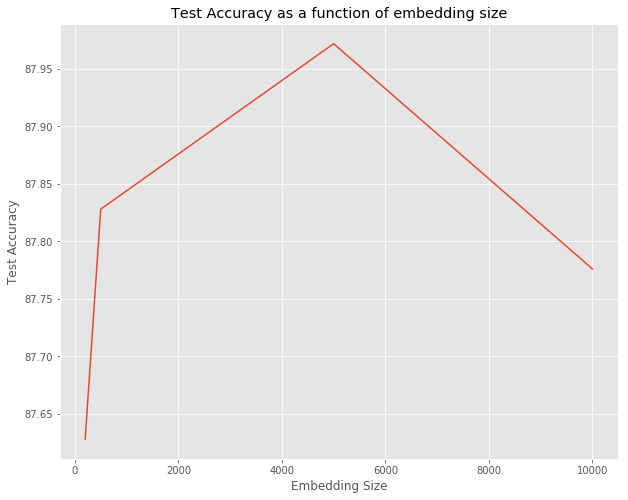

In [128]:
plt.figure()
plt.title('Test Accuracy as a function of embedding size')
plt.plot([200, 500, 5000, 10000], embed_test_acc)
plt.xlabel('Embedding Size')
plt.ylabel('Test Accuracy')

In [129]:
lrs = []
lr_test_acc = []

for i in [0.01, 0.001, 1e-6, 1e-8]:
    temp = hyper_parameter_tune_lr_embedding(learning_rate=i)
    lrs.append(temp)
    lr_test_acc.append(temp[2])
    print('Test Accuracy for LR = {}: {}'.format(i, temp[2]))

Epoch: [1/5], Step: [640/718], Loss: 0.3247055113315582, Train Acc: 94.29130434782608, Validation Acc:87.3
Epoch: [2/5], Step: [640/718], Loss: 0.12790276110172272, Train Acc: 97.97391304347826, Validation Acc:87.6
Epoch: [3/5], Step: [640/718], Loss: 0.07010607421398163, Train Acc: 99.22173913043478, Validation Acc:87.5
Epoch: [4/5], Step: [640/718], Loss: 0.028341982513666153, Train Acc: 99.74347826086957, Validation Acc:86.95
Epoch: [5/5], Step: [640/718], Loss: 0.005895763635635376, Train Acc: 99.95652173913044, Validation Acc:87.55
Test Accuracy for LR = 0.01: 82.848
Epoch: [1/5], Step: [640/718], Loss: 0.5095542669296265, Train Acc: 80.92608695652174, Validation Acc:79.2
Epoch: [2/5], Step: [640/718], Loss: 0.3965980112552643, Train Acc: 88.83043478260869, Validation Acc:85.5
Epoch: [3/5], Step: [640/718], Loss: 0.2846183776855469, Train Acc: 91.47826086956522, Validation Acc:86.7
Epoch: [4/5], Step: [640/718], Loss: 0.26561790704727173, Train Acc: 93.00434782608696, Validation A

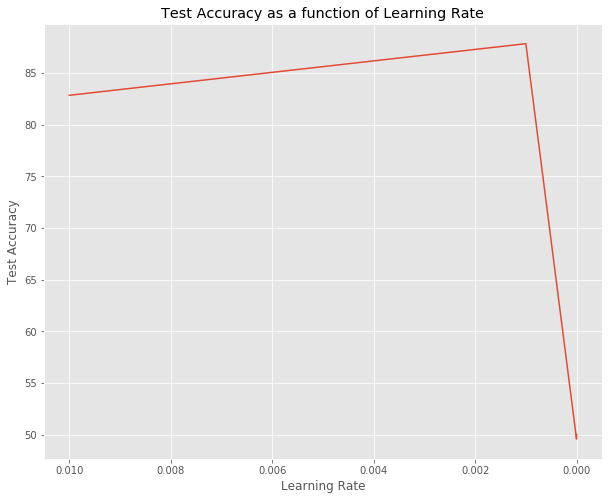

In [138]:
plt.figure()
plt.title('Test Accuracy as a function of Learning Rate')
plt.plot([0.01, 0.001, 1e-6, 1e-8], lr_test_acc)
plt.gca().invert_xaxis()
plt.xlabel('Learning Rate')
plt.ylabel('Test Accuracy')

In [ ]:
vocabs = []
vocabs_test_acc = []

for i in [200, 5000, 20000, 40000, 80000]:
    temp = hyper_parameter_tune_lr_embedding(vocab_size=i)
    vocabs.append(temp)
    vocabs_test_acc.append(temp[2])
    print('Test Accuracy for Vocab Size = {}: {}'.format(i, temp[2]))

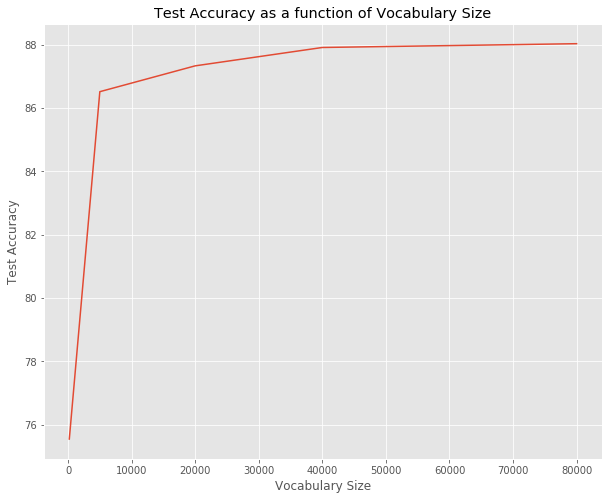

In [139]:
plt.figure()
plt.title('Test Accuracy as a function of Vocabulary Size')
plt.plot([200, 5000, 20000, 40000, 80000], vocabs_test_acc)
plt.xlabel('Vocabulary Size')
plt.ylabel('Test Accuracy')

In [ ]:
grid = []

for embed in [10, 20, 50, 100]:
    emb_g = []
    for voc in [500, 5000, 10000, 20000, 30000]:
        emb_g.append(hyper_parameter_tune_lr_embedding(embedding_dim=embed, vocab_size=voc))
    grid.append(emb_g)

Epoch: [1/5], Step: [640/718], Loss: 0.6156274676322937, Train Acc: 66.37391304347825, Validation Acc:66.35
Epoch: [2/5], Step: [640/718], Loss: 0.5526273250579834, Train Acc: 77.94347826086957, Validation Acc:77.05
Epoch: [3/5], Step: [640/718], Loss: 0.6010174751281738, Train Acc: 79.70869565217392, Validation Acc:78.25
Epoch: [4/5], Step: [640/718], Loss: 0.5472198724746704, Train Acc: 80.53478260869565, Validation Acc:78.4
Epoch: [5/5], Step: [640/718], Loss: 0.41626518964767456, Train Acc: 81.04782608695652, Validation Acc:79.0
Epoch: [1/5], Step: [640/718], Loss: 0.586392343044281, Train Acc: 80.7695652173913, Validation Acc:80.3
Epoch: [2/5], Step: [640/718], Loss: 0.364675909280777, Train Acc: 86.07391304347826, Validation Acc:84.45
Epoch: [3/5], Step: [640/718], Loss: 0.43994733691215515, Train Acc: 88.06521739130434, Validation Acc:85.9
Epoch: [4/5], Step: [640/718], Loss: 0.21216529607772827, Train Acc: 89.01739130434783, Validation Acc:85.7
Epoch: [5/5], Step: [640/718], Lo

In [142]:
train = np.empty((4, 5))
valid = np.empty((4, 5))
tests = np.empty((4, 5))

for i in np.arange(4):
    for j in np.arange(5):
        train[i, j] = np.min(grid[i][j][0])
        valid[i, j] = np.min(grid[i][j][1])
        tests[i, j] = grid[i][j][2]

In [143]:
from mpl_toolkits.mplot3d import axes3d

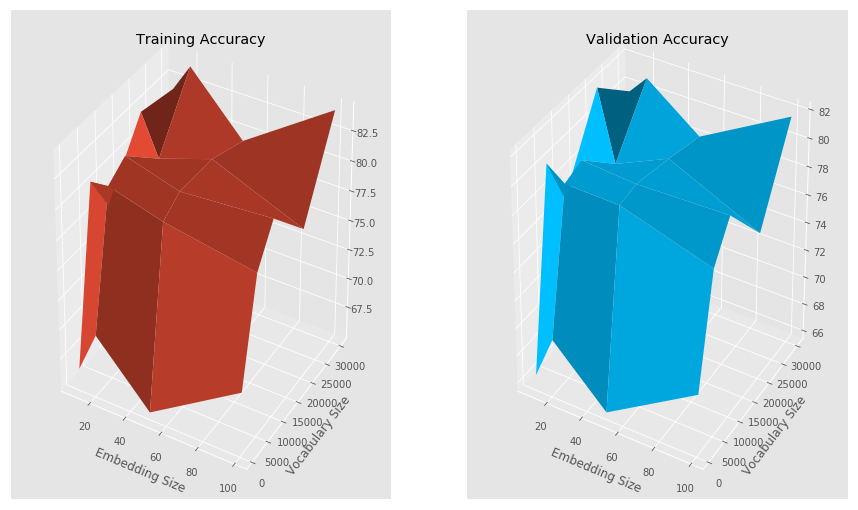

In [173]:
X = [10, 20, 50, 100]
Y = [500, 5000, 10000, 20000, 30000]

X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize=(15, 9))
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title('Training Accuracy')
ax1.plot_surface(X, Y, train.T)
ax1.set_xlabel('Embedding Size')
ax1.set_ylabel('Vocabulary Size')
#ax.plot_surface(X, Y, valid.T)
#ax.plot_surface(X, Y, tests.T)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.set_title('Validation Accuracy')
#ax.plot_surface(X, Y, train.T)
ax2.set_xlabel('Embedding Size')
ax2.set_ylabel('Vocabulary Size')
ax2.plot_surface(X, Y, valid.T, color='DeepSkyBlue')
#ax.plot_surface(X, Y, tests.T)

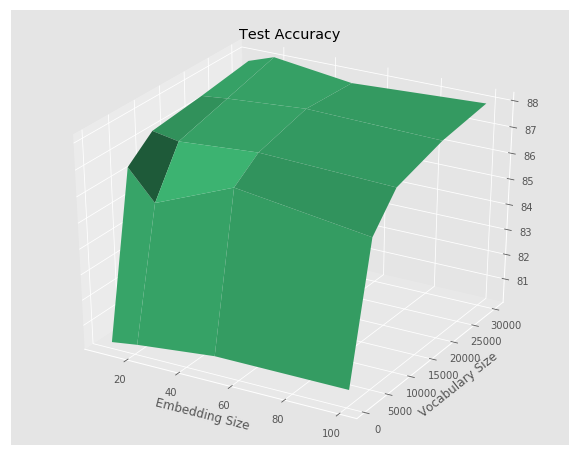

In [177]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111, projection='3d')
ax1.set_title('Test Accuracy')
ax1.set_xlabel('Embedding Size')
ax1.set_ylabel('Vocabulary Size')
#ax.plot_surface(X, Y, valid.T)
ax1.plot_surface(X, Y, tests.T, color='MediumSeaGreen')

In [181]:
X = [10, 20, 50, 100]
Y = [500, 5000, 10000, 20000, 30000]

In [190]:
print('The best test accuracy of {:.2f}% is achieved when Embedding Size = {}, Vocabulary Size = {}'.format(np.max(tests), X[np.where(tests == np.max(tests))[0][0]],Y[np.where(tests == np.max(tests))[1][0]])) 

The best test accuracy of 88.15% is achieved when Embedding Size = 20, Vocabulary Size = 30000


## Early Stopping

In [192]:
train_data, train_ngram_indexer = process_text_dataset(train_set, ngram_n, vocab_size)
validation_data, _ = process_text_dataset(validation_set, ngram_n, ngram_indexer=train_ngram_indexer)
test_data, _ = process_text_dataset(test_set, ngram_n, ngram_indexer=train_ngram_indexer)
# consturct datasets
imdb_train = IMDBDataset(train_data)
imdb_validation = IMDBDataset(validation_data)
imdb_test = IMDBDataset(test_data)    

# construct data loader
train_loader = torch.utils.data.DataLoader(dataset=imdb_train, 
                                           batch_size=batch_size,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=imdb_validation, 
                                           batch_size=batch_size, 
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=imdb_test, 
                                           batch_size=batch_size,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)
model_early = FastText(vocab_size, emb_dim)
criterion = nn.BCELoss()  
optimizer = torch.optim.Adam(model_early.parameters(), lr=0.001) 
# Training the Model
train_acc_history = []
validation_acc_history = []
stop_training = False
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        data_batch, length_batch, label_batch = Variable(data), Variable(lengths), Variable(labels)
        optimizer.zero_grad()
        try:
            outputs = model_early(data_batch, length_batch)
        except:
            print("Doesn't work for: " , torch.max(data_batch))
        loss = criterion(outputs, label_batch.float())
        loss.backward()
        optimizer.step()
        # report performance
        if (i+1) % (batch_size*4) == 0:
            train_acc = test_model(train_loader, model_early)
            val_acc = test_model(validation_loader, model_early)
            print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Train Acc: {5}, Validation Acc:{6}'.format( 
                   epoch+1, num_epochs, i+1, len(imdb_train)//batch_size, loss.data[0], 
                    train_acc, val_acc))
            validation_acc_history.append(val_acc)
            # check if we need to early stop the model
            stop_training = early_stop(validation_acc_history, required_progress=0.001)
            if stop_training:
                print("early stop triggered")
                break
    # because of the the nested loop
    if stop_training:
        break
        
# Test the Model
print('Accuracy of the Early Stopped model on the test set: %d %%' % test_model(test_loader, model_early))
print('Accuracy of the Original model on the test set: %d %%' % test_model(test_loader, model_early))

# Save the Model
#torch.save(net.state_dict(), 'model.pkl')

Epoch: [1/5], Step: [128/718], Loss: 0.6757122874259949, Train Acc: 61.29565217391304, Validation Acc:60.65
Epoch: [1/5], Step: [256/718], Loss: 0.6821480393409729, Train Acc: 58.97391304347826, Validation Acc:57.9
Epoch: [1/5], Step: [384/718], Loss: 0.637744128704071, Train Acc: 67.64782608695653, Validation Acc:66.6
Epoch: [1/5], Step: [512/718], Loss: 0.5923850536346436, Train Acc: 79.87391304347825, Validation Acc:78.0
Epoch: [1/5], Step: [640/718], Loss: 0.5756114721298218, Train Acc: 81.4304347826087, Validation Acc:80.05
Epoch: [2/5], Step: [128/718], Loss: 0.42965441942214966, Train Acc: 83.65652173913044, Validation Acc:80.95
Epoch: [2/5], Step: [256/718], Loss: 0.33595460653305054, Train Acc: 86.84782608695652, Validation Acc:84.35
Epoch: [2/5], Step: [384/718], Loss: 0.35084646940231323, Train Acc: 87.66956521739131, Validation Acc:84.9
Epoch: [2/5], Step: [512/718], Loss: 0.3770034611225128, Train Acc: 87.20434782608696, Validation Acc:83.75
Epoch: [2/5], Step: [640/718], 

## Reference

Joulin, A., Grave, E., Bojanowski, P., & Mikolov, T. (2016). Bag of tricks for efficient text classification. arXiv preprint arXiv:1607.01759.